In [1]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

In [2]:
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of edges: {data.num_edges}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}') # nodes not connected by edges
print(f'Graph has loops: {data.has_self_loops()}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7
Number of edges: 10556
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
Average node degree: 3.90


In [3]:
data.train_mask.sum().item() # train_mask denotes against which nodes to train (140 nodes)
data.val_mask.sum().item() # val_mask denotes which nodes to use for validation, e.g., to perform early stopping (500 nodes)
data.test_mask.sum().item() # test_mask denotes against which nodes to test (1000 nodes).

1000

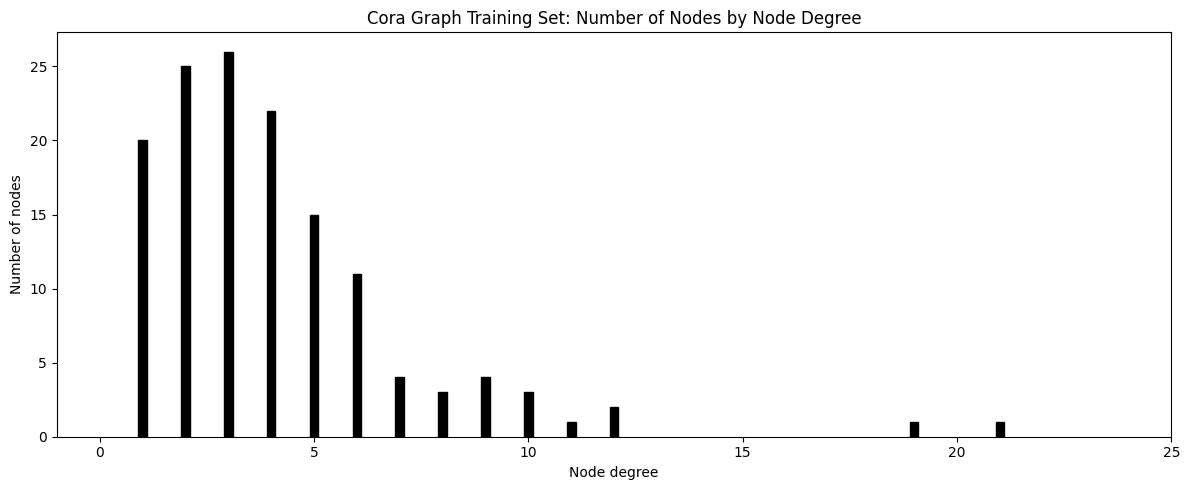

Counter({3.0: 26, 2.0: 25, 4.0: 22, 1.0: 20, 5.0: 15, 6.0: 11, 7.0: 4, 9.0: 4, 8.0: 3, 10.0: 3, 12.0: 2, 36.0: 1, 11.0: 1, 21.0: 1, 32.0: 1, 19.0: 1})


In [25]:
#Plot the number of nodes per node degree
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()
# Select degrees of nodes in test set
degrees=degrees[data.train_mask.numpy()]

numbers = Counter(degrees)

fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
ax.set_xlim([-1, 25])
plt.bar(numbers.keys(), numbers.values(),width=0.2, color='black', edgecolor='black')
plt.title('Cora Graph Training Set: Number of Nodes by Node Degree')
plt.tight_layout()
plt.savefig('Cora_Graph_Train_Node_Degrees.png')

plt.show()

print(numbers)

In [2]:
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import torch.optim as optim
import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import random
random.seed(0)

torch.manual_seed(0)

class GAT(nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, num_heads, heads_p_dropout,size_gat, p_dropout):
        super(GAT, self).__init__()
        self.convs = torch.nn.ModuleList()
        
        self.convs.append(GATv2Conv(num_features, hidden_channels, heads=num_heads,dropout=heads_p_dropout))

        for i in range(size_gat):
            self.convs.append(GATv2Conv(hidden_channels*num_heads, hidden_channels, heads=num_heads))

        #add dropout layer
        self.dropout = nn.Dropout(p=p_dropout)

        # Output layer
        self.convs.append(GATv2Conv(hidden_channels*num_heads, num_classes, heads=1))   # concat=False means that the 
                                                                                    # multihead attentions are averaged
        self.act = F.leaky_relu
        #self.act = F.elu
        
    # Model with leading dropout
    # def forward(self, x, edge_index):
    #     for conv in self.convs:
    #         x = self.dropout(x)
    #         x = conv(x, edge_index)

    #         if conv != self.convs[-1]:
    #             x = self.act(x)

    #     return F.softmax(x, dim=1)

    # Model w/o leading dropout
    def forward(self, x, edge_index):
        for conv in self.convs:
            if conv == self.convs[0]:
                x = conv(x, edge_index)
                x = self.act(x)
            elif conv in self.convs[1:-2]:
                x = self.dropout(x)
                x = conv(x, edge_index)
                x = self.act(x)
            else:
                x = self.dropout(x)
                x = conv(x, edge_index)

        return F.softmax(x, dim=1)

In [3]:
import optuna
from optuna.pruners import SuccessiveHalvingPruner, NopPruner
from torch.optim import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam
import numpy as np

n_trails = 100
n_jobs = 5 # Number of parallel jobs

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [8,16,32,64,128,256]) #try [16,32,64,128,256]
    size_gat = trial.suggest_categorical('hidden_layers', [0,1,2])
    p_dropout = trial.suggest_float('p_dropout', 0.4, 0.7)
    batch_size=trial.suggest_categorical('batch_size', [140]) # entire training set / batch training
    epochs = trial.suggest_categorical('epochs', np.arange(10,130,10).tolist())
    #optimizer = trial.suggest_categorical('optimizer', [SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam])
    optimizer = trial.suggest_categorical('optimizer', [Adamax])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)
    num_heads = trial.suggest_categorical('num_heads', [4,8,16])
    heads_p_dropout = trial.suggest_float('heads_p_dropout', 0.1, 0.7)
    
    data = dataset[0]
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    #(self, num_features, num_classes, hidden_channels, dropout, num_heads, size_gat)
    model = GAT(num_features=data.num_features, num_classes=dataset.num_classes, hidden_channels=hidden_channels, 
                num_heads=num_heads, heads_p_dropout=heads_p_dropout,size_gat=size_gat, p_dropout=p_dropout)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)#, momentum=0.9) #for RMSprop

    for epoch in range(1, epochs+1):
        for data in loader:
            criterion=nn.CrossEntropyLoss()
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            trial.report(loss, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Validate model
    model.eval()
    out = model(data.x, data.edge_index)  # Predicted probabilities
    probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probas.argmax(dim=1)

    # Only consider validation data
    true_labels = data.y[data.val_mask].cpu().numpy()
    predicted_labels = pred[data.val_mask].cpu().numpy()

    # Recall
    recall = recall_score(true_labels, predicted_labels, average='macro')  # Using macro average

    # Acuracy
    correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    acc = correct / data.val_mask.sum().item()
    print(f'Validation Accuracy: {acc * 100:.2f}%')
    
    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    #append the metrics to a csv file, and include the columns: avg_auc, recall, acc, f1
    with open('GAT_cora_test_results04.csv', 'a') as f:
        optimizer_name=optimizer.__class__.__name__
        f.write(f'{batch_size}, {hidden_channels}, {num_heads},{size_gat},{heads_p_dropout},{lr}, {weight_decay}, {epochs}, {p_dropout}, {optimizer_name},{recall},{acc},{f1}\n')
    
    return acc

study = optuna.create_study(direction="maximize", pruner=NopPruner())
#study = optuna.create_study(direction="minimize", pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=4, min_early_stopping_rate=0))
study.optimize(objective, n_trials=n_trails, timeout=6000, n_jobs=n_jobs,show_progress_bar = True)
print(study.best_trial)

[I 2023-12-01 12:03:18,084] A new study created in memory with name: no-name-3dce8947-2cb8-4705-8ff1-5d0640bd9228
C:\Users\ramme\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 79.40%
[I 2023-12-01 12:03:23,117] Trial 0 finished with value: 0.794 and parameters: {'lr': 0.004502566252914796, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.5841132205051996, 'batch_size': 140, 'epochs': 20, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006154776247554489, 'num_heads': 8, 'heads_p_dropout': 0.4254030482286464}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.80%
[I 2023-12-01 12:03:32,421] Trial 3 finished with value: 0.728 and parameters: {'lr': 0.001230394611525046, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.5083316326701547, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006563041666574694, 'num_heads': 4, 'heads_p_dropout': 0.5261953115051189}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.20%
[I 2023-12-01 12:03:35,802] Trial 2 finished with value: 0.782 and parameters: {'lr': 0.0016117431989144924, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.4588459453216196, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0064249733726712745, 'num_heads': 16, 'heads_p_dropout': 0.4598957078446265}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 15.80%
[I 2023-12-01 12:03:41,533] Trial 5 finished with value: 0.158 and parameters: {'lr': 8.140761198755991e-05, 'hidden_channels': 16, 'hidden_layers': 2, 'p_dropout': 0.6817617512795137, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0086742580222292, 'num_heads': 4, 'heads_p_dropout': 0.3074780862463606}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 74.20%
[I 2023-12-01 12:03:55,368] Trial 6 finished with value: 0.742 and parameters: {'lr': 0.009016260370527088, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.6160422745522731, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0003507133833767252, 'num_heads': 8, 'heads_p_dropout': 0.23895600707050577}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 41.40%
[I 2023-12-01 12:04:02,313] Trial 1 finished with value: 0.414 and parameters: {'lr': 0.0003005153197293373, 'hidden_channels': 8, 'hidden_layers': 2, 'p_dropout': 0.617107509616511, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0017418226723899949, 'num_heads': 4, 'heads_p_dropout': 0.4507596419240252}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 28.00%
[I 2023-12-01 12:04:04,333] Trial 7 finished with value: 0.28 and parameters: {'lr': 6.730527256101994e-05, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.6153320970945599, 'batch_size': 140, 'epochs': 90, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.008568563049317253, 'num_heads': 8, 'heads_p_dropout': 0.30156340209690624}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 39.40%
[I 2023-12-01 12:04:10,732] Trial 8 finished with value: 0.394 and parameters: {'lr': 0.00030673243121785373, 'hidden_channels': 128, 'hidden_layers': 2, 'p_dropout': 0.6731994579889855, 'batch_size': 140, 'epochs': 20, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0037002252220218208, 'num_heads': 8, 'heads_p_dropout': 0.2680480293679655}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 75.20%
[I 2023-12-01 12:04:11,308] Trial 4 finished with value: 0.752 and parameters: {'lr': 0.0016243590974230632, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.632223404515701, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007097607053147957, 'num_heads': 8, 'heads_p_dropout': 0.38871791000578904}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 17.00%
[I 2023-12-01 12:04:12,893] Trial 11 finished with value: 0.17 and parameters: {'lr': 0.00017627095651619773, 'hidden_channels': 8, 'hidden_layers': 1, 'p_dropout': 0.43082890235628357, 'batch_size': 140, 'epochs': 30, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.003418017852835346, 'num_heads': 4, 'heads_p_dropout': 0.10351152063149681}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 32.40%
[I 2023-12-01 12:04:14,724] Trial 9 finished with value: 0.324 and parameters: {'lr': 3.3819200588071776e-05, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.5174568909548178, 'batch_size': 140, 'epochs': 90, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005051808980952882, 'num_heads': 4, 'heads_p_dropout': 0.5946272781432118}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 30.20%
[I 2023-12-01 12:04:28,196] Trial 10 finished with value: 0.302 and parameters: {'lr': 4.2647881104596375e-05, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.44312048681820315, 'batch_size': 140, 'epochs': 90, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.001645119789529942, 'num_heads': 8, 'heads_p_dropout': 0.45319492278474893}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 74.40%
[I 2023-12-01 12:05:22,894] Trial 12 finished with value: 0.744 and parameters: {'lr': 0.005158482733605014, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.6066555398823607, 'batch_size': 140, 'epochs': 80, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0060276908356067405, 'num_heads': 8, 'heads_p_dropout': 0.12020223494258378}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.00%
[I 2023-12-01 12:05:24,338] Trial 15 finished with value: 0.78 and parameters: {'lr': 0.0043657927677245275, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.43167451238864685, 'batch_size': 140, 'epochs': 80, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.00985399181089579, 'num_heads': 16, 'heads_p_dropout': 0.6349777307903997}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 60.20%
[I 2023-12-01 12:06:38,994] Trial 18 finished with value: 0.602 and parameters: {'lr': 0.0011558071434970378, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.5495600777603367, 'batch_size': 140, 'epochs': 20, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005385266102386712, 'num_heads': 16, 'heads_p_dropout': 0.6889568457166292}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 23.80%
[I 2023-12-01 12:06:46,681] Trial 13 finished with value: 0.238 and parameters: {'lr': 3.4893035844948245e-05, 'hidden_channels': 16, 'hidden_layers': 2, 'p_dropout': 0.6576603042181213, 'batch_size': 140, 'epochs': 90, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.00901862879795728, 'num_heads': 4, 'heads_p_dropout': 0.3660301072654908}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.80%
[I 2023-12-01 12:06:57,557] Trial 16 finished with value: 0.778 and parameters: {'lr': 0.003525065100500933, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.5564871185388786, 'batch_size': 140, 'epochs': 50, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006509650125604434, 'num_heads': 16, 'heads_p_dropout': 0.6731345280762997}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.80%
[I 2023-12-01 12:09:23,211] Trial 17 finished with value: 0.768 and parameters: {'lr': 0.001689761837022511, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.5454757138805374, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.009637957561203964, 'num_heads': 16, 'heads_p_dropout': 0.61595060727181}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 27.40%
[I 2023-12-01 12:09:52,504] Trial 21 finished with value: 0.274 and parameters: {'lr': 1.350401987300251e-05, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.40994135470091475, 'batch_size': 140, 'epochs': 100, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007385549279174438, 'num_heads': 16, 'heads_p_dropout': 0.5396356771720484}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 35.00%
[I 2023-12-01 12:10:04,997] Trial 14 finished with value: 0.35 and parameters: {'lr': 1.7747186185598197e-05, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.5470786011843539, 'batch_size': 140, 'epochs': 110, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.00993660818325022, 'num_heads': 16, 'heads_p_dropout': 0.6938957713456421}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 58.40%
[I 2023-12-01 12:10:21,297] Trial 24 finished with value: 0.584 and parameters: {'lr': 0.0006035228857454043, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.47477911872558193, 'batch_size': 140, 'epochs': 10, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.00765612822047829, 'num_heads': 16, 'heads_p_dropout': 0.4614832721000455}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.00%
[I 2023-12-01 12:10:32,661] Trial 20 finished with value: 0.76 and parameters: {'lr': 0.002111670305860345, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.4633994421237496, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0076299809589949405, 'num_heads': 16, 'heads_p_dropout': 0.5080503972198218}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 23.60%
[I 2023-12-01 12:10:33,616] Trial 19 finished with value: 0.236 and parameters: {'lr': 1.3675113964153546e-05, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.4004154307023642, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007385008839988917, 'num_heads': 16, 'heads_p_dropout': 0.5048475783537292}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 17.60%
[I 2023-12-01 12:10:47,386] Trial 22 finished with value: 0.176 and parameters: {'lr': 1.0367326560892603e-05, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.40594830619669475, 'batch_size': 140, 'epochs': 100, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007546276141344381, 'num_heads': 16, 'heads_p_dropout': 0.505438502606996}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.20%
[I 2023-12-01 12:10:51,398] Trial 25 finished with value: 0.772 and parameters: {'lr': 0.0031801571685081023, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.40036083024951985, 'batch_size': 140, 'epochs': 80, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007901688294843789, 'num_heads': 16, 'heads_p_dropout': 0.5187299416547761}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.40%
[I 2023-12-01 12:10:55,362] Trial 26 finished with value: 0.764 and parameters: {'lr': 0.009851490708156333, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.4246304226157048, 'batch_size': 140, 'epochs': 80, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.008067002995114314, 'num_heads': 16, 'heads_p_dropout': 0.5878245540010132}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.40%
[I 2023-12-01 12:10:56,029] Trial 27 finished with value: 0.764 and parameters: {'lr': 0.004149715871320537, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.47267216421164143, 'batch_size': 140, 'epochs': 80, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005720632539225887, 'num_heads': 16, 'heads_p_dropout': 0.5822875759021878}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 63.80%
[I 2023-12-01 12:10:58,824] Trial 30 finished with value: 0.638 and parameters: {'lr': 0.004663005039791747, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.4547852335540218, 'batch_size': 140, 'epochs': 20, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.009241655542794807, 'num_heads': 8, 'heads_p_dropout': 0.4252755753348664}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 20.60%
[I 2023-12-01 12:11:01,610] Trial 32 finished with value: 0.206 and parameters: {'lr': 0.0008175210404200101, 'hidden_channels': 16, 'hidden_layers': 1, 'p_dropout': 0.49068238142544235, 'batch_size': 140, 'epochs': 10, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0046849061071254005, 'num_heads': 8, 'heads_p_dropout': 0.6509156227089881}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 48.80%
[I 2023-12-01 12:11:03,759] Trial 31 finished with value: 0.488 and parameters: {'lr': 0.005476758494351832, 'hidden_channels': 16, 'hidden_layers': 2, 'p_dropout': 0.4484635094440384, 'batch_size': 140, 'epochs': 20, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0045010483801341886, 'num_heads': 8, 'heads_p_dropout': 0.629927615387484}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.00%
[I 2023-12-01 12:11:04,979] Trial 29 finished with value: 0.78 and parameters: {'lr': 0.008866581683731084, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.4791207008873486, 'batch_size': 140, 'epochs': 80, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0058959525855764765, 'num_heads': 8, 'heads_p_dropout': 0.5969126979102414}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 75.80%
[I 2023-12-01 12:11:06,534] Trial 28 finished with value: 0.758 and parameters: {'lr': 0.00864988697869746, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.4693808006601571, 'batch_size': 140, 'epochs': 80, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0057365548931521725, 'num_heads': 16, 'heads_p_dropout': 0.5921929020811177}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 56.60%
[I 2023-12-01 12:11:08,278] Trial 23 finished with value: 0.566 and parameters: {'lr': 0.0005789465954159444, 'hidden_channels': 16, 'hidden_layers': 1, 'p_dropout': 0.4748204446049018, 'batch_size': 140, 'epochs': 110, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007859476853119652, 'num_heads': 16, 'heads_p_dropout': 0.4678373990088583}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.80%
[I 2023-12-01 12:11:12,283] Trial 36 finished with value: 0.718 and parameters: {'lr': 0.0027479641942969608, 'hidden_channels': 8, 'hidden_layers': 0, 'p_dropout': 0.42666429739502587, 'batch_size': 140, 'epochs': 50, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.00669845353175961, 'num_heads': 8, 'heads_p_dropout': 0.5526407919677637}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.20%
[I 2023-12-01 12:11:15,029] Trial 35 finished with value: 0.782 and parameters: {'lr': 0.0025537214164009516, 'hidden_channels': 8, 'hidden_layers': 0, 'p_dropout': 0.43611018739180357, 'batch_size': 140, 'epochs': 80, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0064478321792865246, 'num_heads': 8, 'heads_p_dropout': 0.5629003211829376}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 25.00%
[I 2023-12-01 12:11:15,311] Trial 34 finished with value: 0.25 and parameters: {'lr': 0.0026271490214769735, 'hidden_channels': 8, 'hidden_layers': 2, 'p_dropout': 0.5828898092447928, 'batch_size': 140, 'epochs': 30, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006586213511287131, 'num_heads': 16, 'heads_p_dropout': 0.5664838130460994}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.60%
[I 2023-12-01 12:11:28,421] Trial 37 finished with value: 0.776 and parameters: {'lr': 0.0025668502213000294, 'hidden_channels': 8, 'hidden_layers': 0, 'p_dropout': 0.4333919702843186, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006567626194443275, 'num_heads': 8, 'heads_p_dropout': 0.553655274293631}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 79.00%
[I 2023-12-01 12:11:31,258] Trial 38 finished with value: 0.79 and parameters: {'lr': 0.0021954630293064175, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.4982605169038479, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0063841515162036755, 'num_heads': 8, 'heads_p_dropout': 0.6457233999625464}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 59.40%
[I 2023-12-01 12:11:41,378] Trial 41 finished with value: 0.594 and parameters: {'lr': 0.0015343860514416146, 'hidden_channels': 8, 'hidden_layers': 0, 'p_dropout': 0.4986080905566189, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006998063036025106, 'num_heads': 8, 'heads_p_dropout': 0.4145069501475695}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 46.00%
[I 2023-12-01 12:11:42,268] Trial 33 finished with value: 0.46 and parameters: {'lr': 0.0027417681283714856, 'hidden_channels': 8, 'hidden_layers': 2, 'p_dropout': 0.44068974472948164, 'batch_size': 140, 'epochs': 110, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.008586561251514201, 'num_heads': 8, 'heads_p_dropout': 0.6289624042352536}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.40%
[I 2023-12-01 12:12:05,513] Trial 40 finished with value: 0.784 and parameters: {'lr': 0.0018087849038960744, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.43853626819894836, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.008443534284119602, 'num_heads': 8, 'heads_p_dropout': 0.6404824029474383}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.60%
[I 2023-12-01 12:12:16,434] Trial 44 finished with value: 0.706 and parameters: {'lr': 0.0010672101535708065, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.45389874493663357, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006262478153976015, 'num_heads': 8, 'heads_p_dropout': 0.3765063301878383}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.20%
[I 2023-12-01 12:12:37,998] Trial 39 finished with value: 0.762 and parameters: {'lr': 0.0024265966002663727, 'hidden_channels': 8, 'hidden_layers': 2, 'p_dropout': 0.43610995783535866, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006841297555238063, 'num_heads': 8, 'heads_p_dropout': 0.5594516356728636}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 51.00%
[I 2023-12-01 12:12:55,995] Trial 42 finished with value: 0.51 and parameters: {'lr': 0.0014514544917800544, 'hidden_channels': 128, 'hidden_layers': 2, 'p_dropout': 0.49324690109190356, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007064448409242096, 'num_heads': 8, 'heads_p_dropout': 0.40741805664835484}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 57.00%
[I 2023-12-01 12:13:05,928] Trial 43 finished with value: 0.57 and parameters: {'lr': 0.0012152398566322687, 'hidden_channels': 128, 'hidden_layers': 2, 'p_dropout': 0.5147329446086206, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0061811640581049656, 'num_heads': 8, 'heads_p_dropout': 0.37502325982432627}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 79.00%
[I 2023-12-01 12:13:17,340] Trial 45 finished with value: 0.79 and parameters: {'lr': 0.001205812241865269, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.5125149028212348, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007073951232581218, 'num_heads': 8, 'heads_p_dropout': 0.4798358356219987}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 75.60%
[I 2023-12-01 12:13:21,139] Trial 46 finished with value: 0.756 and parameters: {'lr': 0.0021452437833317413, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.5173229809730587, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0069010197738269205, 'num_heads': 8, 'heads_p_dropout': 0.6688083419233333}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.60%
[I 2023-12-01 12:13:34,132] Trial 47 finished with value: 0.766 and parameters: {'lr': 0.0016354656302801263, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.5202910310644956, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006119562981213793, 'num_heads': 8, 'heads_p_dropout': 0.6579856111123112}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.00%
[I 2023-12-01 12:13:37,867] Trial 48 finished with value: 0.78 and parameters: {'lr': 0.0018834886434975597, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.5142781645668749, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.00833776052602343, 'num_heads': 4, 'heads_p_dropout': 0.6444762663474618}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.00%
[I 2023-12-01 12:13:41,942] Trial 49 finished with value: 0.76 and parameters: {'lr': 0.0019618985018030363, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.45492140594362884, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.008282487267353523, 'num_heads': 4, 'heads_p_dropout': 0.6647505906777239}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.20%
[I 2023-12-01 12:13:52,964] Trial 50 finished with value: 0.782 and parameters: {'lr': 0.0019283197128053136, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.5235536358616264, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007043479152817883, 'num_heads': 4, 'heads_p_dropout': 0.4680529919694035}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.60%
[I 2023-12-01 12:13:54,447] Trial 51 finished with value: 0.776 and parameters: {'lr': 0.0017042641429793129, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.530465570221566, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.008187427996936416, 'num_heads': 4, 'heads_p_dropout': 0.4796336616941192}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 75.60%
[I 2023-12-01 12:14:14,425] Trial 53 finished with value: 0.756 and parameters: {'lr': 0.005786698892428948, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.4892430748835511, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0051889522256302655, 'num_heads': 4, 'heads_p_dropout': 0.34970895252687073}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.60%
[I 2023-12-01 12:14:16,322] Trial 56 finished with value: 0.766 and parameters: {'lr': 0.0037080159066930976, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.48267836817654025, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005520775178571191, 'num_heads': 8, 'heads_p_dropout': 0.4280836223957693}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.60%
[I 2023-12-01 12:14:22,738] Trial 55 finished with value: 0.766 and parameters: {'lr': 0.003657927711155215, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.48995283717375, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005450430193717248, 'num_heads': 8, 'heads_p_dropout': 0.4883033652482772}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.40%
[I 2023-12-01 12:14:31,004] Trial 54 finished with value: 0.784 and parameters: {'lr': 0.0009121391707240818, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5321853128655246, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005349330359504706, 'num_heads': 8, 'heads_p_dropout': 0.33264871499722004}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 57.20%
[I 2023-12-01 12:14:36,987] Trial 59 finished with value: 0.572 and parameters: {'lr': 0.0009025195183140174, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.4580475544175325, 'batch_size': 140, 'epochs': 20, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007239406772496467, 'num_heads': 8, 'heads_p_dropout': 0.5213399170991607}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.20%
[I 2023-12-01 12:14:39,893] Trial 52 finished with value: 0.762 and parameters: {'lr': 0.0008148079441126733, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5033349072006441, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0081473103865143, 'num_heads': 4, 'heads_p_dropout': 0.48620178814151543}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 79.00%
[I 2023-12-01 12:14:41,919] Trial 57 finished with value: 0.79 and parameters: {'lr': 0.0035148206817066023, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.46158021032047286, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005536474383164867, 'num_heads': 8, 'heads_p_dropout': 0.4362410541311367}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.80%
[I 2023-12-01 12:14:55,379] Trial 58 finished with value: 0.778 and parameters: {'lr': 0.0008992189314316935, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.46376002228363794, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006357853079487593, 'num_heads': 8, 'heads_p_dropout': 0.44496029800324943}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 58.80%
[I 2023-12-01 12:15:15,430] Trial 60 finished with value: 0.588 and parameters: {'lr': 0.0009076405436083643, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5074165797907666, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006030614130543649, 'num_heads': 8, 'heads_p_dropout': 0.4453873140881327}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 65.20%
[I 2023-12-01 12:15:16,336] Trial 62 finished with value: 0.652 and parameters: {'lr': 0.0013638592410806017, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5039314552770927, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006220415099310584, 'num_heads': 8, 'heads_p_dropout': 0.4402753794028507}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.40%
[I 2023-12-01 12:15:19,274] Trial 63 finished with value: 0.784 and parameters: {'lr': 0.0012625305737144971, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5022490732256951, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.004896101490480132, 'num_heads': 8, 'heads_p_dropout': 0.43586999761909256}. Best is trial 0 with value: 0.794.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 81.00%
[I 2023-12-01 12:15:22,108] Trial 61 finished with value: 0.81 and parameters: {'lr': 0.0013191168503116166, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5048414017214051, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005908460006339683, 'num_heads': 8, 'heads_p_dropout': 0.4423211437386582}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 64.80%
[I 2023-12-01 12:15:26,338] Trial 64 finished with value: 0.648 and parameters: {'lr': 0.0013372003277935768, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.502829790516717, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005928598117101327, 'num_heads': 8, 'heads_p_dropout': 0.6982037579114546}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.80%
[I 2023-12-01 12:15:49,076] Trial 66 finished with value: 0.788 and parameters: {'lr': 0.003139408341632013, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5342438144915399, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.004955809942443973, 'num_heads': 8, 'heads_p_dropout': 0.38947760168798734}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 59.40%
[I 2023-12-01 12:15:49,480] Trial 67 finished with value: 0.594 and parameters: {'lr': 0.0005885441448669, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5366721052555525, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.004988167862896377, 'num_heads': 8, 'heads_p_dropout': 0.40237513030737576}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.20%
[I 2023-12-01 12:15:56,662] Trial 65 finished with value: 0.782 and parameters: {'lr': 0.0011905747256671186, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5037618526670238, 'batch_size': 140, 'epochs': 90, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0049147646538889745, 'num_heads': 8, 'heads_p_dropout': 0.3941867784881426}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 57.40%
[I 2023-12-01 12:16:04,965] Trial 68 finished with value: 0.574 and parameters: {'lr': 0.0005693169140658763, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5398714057182785, 'batch_size': 140, 'epochs': 90, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005795599386667651, 'num_heads': 8, 'heads_p_dropout': 0.39806650103539604}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 64.40%
[I 2023-12-01 12:16:18,832] Trial 69 finished with value: 0.644 and parameters: {'lr': 0.0005174260499503603, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5315677011936825, 'batch_size': 140, 'epochs': 90, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005147698341272835, 'num_heads': 8, 'heads_p_dropout': 0.39149822577148535}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.00%
[I 2023-12-01 12:16:26,087] Trial 74 finished with value: 0.78 and parameters: {'lr': 0.0033390350454987746, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.48481304612636267, 'batch_size': 140, 'epochs': 30, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007491839957251178, 'num_heads': 8, 'heads_p_dropout': 0.533661535066646}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.00%
[I 2023-12-01 12:16:29,729] Trial 70 finished with value: 0.78 and parameters: {'lr': 0.003378595191413496, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5358591037334113, 'batch_size': 140, 'epochs': 90, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005023723421752864, 'num_heads': 8, 'heads_p_dropout': 0.3856403045626025}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 75.00%
[I 2023-12-01 12:16:32,120] Trial 73 finished with value: 0.75 and parameters: {'lr': 0.004299164909184055, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.5595498945865433, 'batch_size': 140, 'epochs': 100, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007456717518121335, 'num_heads': 8, 'heads_p_dropout': 0.5384912332602521}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 75.40%
[I 2023-12-01 12:16:33,128] Trial 71 finished with value: 0.754 and parameters: {'lr': 0.0034372407756232282, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.4822624725713892, 'batch_size': 140, 'epochs': 90, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.004663725929620731, 'num_heads': 8, 'heads_p_dropout': 0.39664583565103123}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.20%
[I 2023-12-01 12:16:44,531] Trial 72 finished with value: 0.772 and parameters: {'lr': 0.0031456324917483697, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.5611093096858482, 'batch_size': 140, 'epochs': 100, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.004420323130629551, 'num_heads': 8, 'heads_p_dropout': 0.5317449695808959}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 75.80%
[I 2023-12-01 12:17:20,231] Trial 75 finished with value: 0.758 and parameters: {'lr': 0.002151610145637388, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5694119233500409, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.004482156023429378, 'num_heads': 8, 'heads_p_dropout': 0.34020809285466924}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.40%
[I 2023-12-01 12:17:27,190] Trial 76 finished with value: 0.764 and parameters: {'lr': 0.0021004697513604446, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5586201615001355, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005563428840670682, 'num_heads': 8, 'heads_p_dropout': 0.3309395612844722}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 75.80%
[I 2023-12-01 12:17:30,770] Trial 77 finished with value: 0.758 and parameters: {'lr': 0.0022550923113721535, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5594955116923374, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005443796620766228, 'num_heads': 8, 'heads_p_dropout': 0.3529335529661014}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.60%
[I 2023-12-01 12:17:34,082] Trial 78 finished with value: 0.786 and parameters: {'lr': 0.0022154642552475847, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.46881229887820425, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.00570533688582006, 'num_heads': 8, 'heads_p_dropout': 0.34997648529157055}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.40%
[I 2023-12-01 12:17:46,754] Trial 79 finished with value: 0.774 and parameters: {'lr': 0.00231406351932821, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5251877553696394, 'batch_size': 140, 'epochs': 70, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005547382253747222, 'num_heads': 8, 'heads_p_dropout': 0.34776973436764885}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.80%
[I 2023-12-01 12:17:56,922] Trial 81 finished with value: 0.778 and parameters: {'lr': 0.005617184071878058, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.5251850743292826, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005757995583771114, 'num_heads': 8, 'heads_p_dropout': 0.41941583283945677}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.60%
[I 2023-12-01 12:18:15,994] Trial 80 finished with value: 0.766 and parameters: {'lr': 0.0050628764635190565, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.4707741855884967, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005593879579458713, 'num_heads': 8, 'heads_p_dropout': 0.6122679141234237}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 75.80%
[I 2023-12-01 12:18:22,692] Trial 83 finished with value: 0.758 and parameters: {'lr': 0.005854014261287484, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.46764154129766805, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006716875542268929, 'num_heads': 8, 'heads_p_dropout': 0.41643943466139527}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 74.60%
[I 2023-12-01 12:18:35,204] Trial 82 finished with value: 0.746 and parameters: {'lr': 0.005796709776677008, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.546249775029008, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0065461606350274, 'num_heads': 8, 'heads_p_dropout': 0.422536650226829}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.80%
[I 2023-12-01 12:18:59,997] Trial 84 finished with value: 0.778 and parameters: {'lr': 0.006384378227638566, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.47178512180395066, 'batch_size': 140, 'epochs': 40, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006697840819073185, 'num_heads': 8, 'heads_p_dropout': 0.42276402124912255}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.00%
[I 2023-12-01 12:20:26,028] Trial 88 finished with value: 0.77 and parameters: {'lr': 0.0017367957567235594, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.44474563622169283, 'batch_size': 140, 'epochs': 50, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005977599815822938, 'num_heads': 8, 'heads_p_dropout': 0.4577154411345198}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.60%
[I 2023-12-01 12:20:39,798] Trial 89 finished with value: 0.766 and parameters: {'lr': 0.0016366598915233575, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.4469450132932909, 'batch_size': 140, 'epochs': 50, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0060254932524087665, 'num_heads': 8, 'heads_p_dropout': 0.4545658363427461}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 46.80%
[I 2023-12-01 12:21:11,196] Trial 90 finished with value: 0.468 and parameters: {'lr': 0.0016318918053187753, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.5139892881444001, 'batch_size': 140, 'epochs': 20, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0052614868830169, 'num_heads': 8, 'heads_p_dropout': 0.30367945226160026}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 65.00%
[I 2023-12-01 12:21:27,376] Trial 92 finished with value: 0.65 and parameters: {'lr': 0.00407805784628723, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.49575961527735624, 'batch_size': 140, 'epochs': 10, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006394115488668492, 'num_heads': 8, 'heads_p_dropout': 0.3686095259965662}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.40%
[I 2023-12-01 12:21:46,152] Trial 85 finished with value: 0.764 and parameters: {'lr': 0.0016508593143101688, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.46510665017554265, 'batch_size': 140, 'epochs': 50, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006620829120669743, 'num_heads': 8, 'heads_p_dropout': 0.3083770882310144}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 48.20%
[I 2023-12-01 12:21:55,792] Trial 91 finished with value: 0.482 and parameters: {'lr': 0.0027883795883242176, 'hidden_channels': 128, 'hidden_layers': 2, 'p_dropout': 0.5121549494726856, 'batch_size': 140, 'epochs': 20, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006427132750081086, 'num_heads': 8, 'heads_p_dropout': 0.3644434804348215}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 74.60%
[I 2023-12-01 12:22:00,415] Trial 86 finished with value: 0.746 and parameters: {'lr': 0.0016039058095125532, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.5102791918486367, 'batch_size': 140, 'epochs': 50, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.0065527466087945, 'num_heads': 8, 'heads_p_dropout': 0.3139536716553981}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.00%
[I 2023-12-01 12:22:06,785] Trial 87 finished with value: 0.76 and parameters: {'lr': 0.001781081443860884, 'hidden_channels': 256, 'hidden_layers': 1, 'p_dropout': 0.4435576740957322, 'batch_size': 140, 'epochs': 50, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.006133124233805371, 'num_heads': 8, 'heads_p_dropout': 0.30600812639090247}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 76.40%
[I 2023-12-01 12:22:31,606] Trial 95 finished with value: 0.764 and parameters: {'lr': 0.0014219239055352814, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.494471940983598, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005798040931020973, 'num_heads': 8, 'heads_p_dropout': 0.4369060544667774}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 77.60%
[I 2023-12-01 12:22:33,009] Trial 96 finished with value: 0.776 and parameters: {'lr': 0.0029642909692842103, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.4927658268462593, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005827878970070445, 'num_heads': 8, 'heads_p_dropout': 0.4342007316790981}. Best is trial 61 with value: 0.81.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adamax.Adamax'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 78.40%
[I 2023-12-01 12:22:37,520] Trial 94 finished with value: 0.784 and parameters: {'lr': 0.0027540533103146037, 'hidden_channels': 64, 'hidden_layers': 0, 'p_dropout': 0.47595511829559634, 'batch_size': 140, 'epochs': 110, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.005319784351739676, 'num_heads': 8, 'heads_p_dropout': 0.6834849604328248}. Best is trial 61 with value: 0.81.
Validation Accuracy: 53.00%
[I 2023-12-01 12:22:38,327] Trial 97 finished with value: 0.53 and parameters: {'lr': 0.001123810010552763, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.4968870028501719, 'batch_size': 140, 'epochs': 60, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'weight_decay': 0.007238321857802193, 'num_heads': 8, 'heads_p_dropout': 0.4336462926658107}. Best is trial 61 with value: 0.81.
Validation Accuracy: 77.40%
[I 2023-12-01 12:22:45,366] Trial 98 finished with value: 0.774 and parameters: {'lr': 0.0011480595690272078, 'hidden_ch

In [4]:
print(study.best_params)

{'lr': 0.00010436594091179323, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.4465534667574045, 'batch_size': 128, 'epochs': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 5.40503466421723e-05, 'num_heads': 8}


In [3]:
import pandas as pd
results_df = pd.read_csv('GAT_cora_test_results04.csv', header=None)
results_df.columns = ['batch_size', 'hidden_channels', 'num_heads','size_gat','heads_p_dropout', 'lr', 'weight_decay', 'epochs', 'p_dropout', 'optimizer', 'recall', 'acc', 'f1']

results_df.sort_values('acc', ascending=False).iloc[:10]
#results_df.loc[results_df['optimizer']]
#results_df[results_df.optimizer.str.contains('Adam')].sort_values('acc', ascending=False).iloc[:5]

#Model with intermediate dropouts
# 128 16 16	0 0.692889	0.000491	0.002541	100	0.597672	Adam	0.826481	0.810	0.795890 | recall 0.811940 acc 0.791800 f1 0.790024
# 256 8	8	1 0.342939	0.003539	0.006355	100	0.615685	Adam	0.818477	0.798	0.788357 | recall 0.799963 acc 0.784200 f1 0.778919
# 16 8 8    1 0.214470	0.001952	0.005183	100	0.561916	Adam	0.821532	0.796	0.786771 | recall 0.806776 acc 0.793900 f1 0.787959
# 256 8	8	0 0.693739	0.001282	0.005451	100	0.695004	Adam	0.808504	0.792	0.777007 | recall 0.821401 acc 0.802500 f1 0.798981

# 16 8	8	1 0.365570	0.003452	0.005054	100	0.515095	RMSprop	0.811762	0.798	0.784681 | recall 0.80490 acc 0.78300 f1 0.78022
# 16 16	8	1 0.361727	0.000210	0.003056	100	0.497582	RMSprop	0.819189	0.792	0.790542 | recall 0.807747 acc 0.787900 f1 0.785956

# 16 16	16	1 0.298358	0.000509	0.006146	200	0.520403	Adamax	0.833137	0.812	0.806787 | recall 0.810468 acc 0.791000 f1 0.788410
# 16 32	16	1 0.221265	0.000761	0.005568	200	0.525549	Adamax	0.807103	0.788	0.775959 | recall 0.798144 acc 0.782200 f1 0.779102

,batch_size,hidden_channels,num_heads,size_gat,heads_p_dropout,lr,weight_decay,epochs,p_dropout,optimizer,recall,acc,f1
264,140,64,8,1,0.442321,0.001319,0.005908,60,0.504841,Adamax,0.820408,0.810,0.796731
178,140,128,8,1,0.699724,0.004374,0.007152,60,0.549744,Adamax,0.823069,0.808,0.797650
86,140,64,8,0,0.620153,0.002870,0.002089,20,0.672601,Adam,0.809805,0.802,0.790469
142,140,32,8,1,0.686240,0.001427,0.000351,20,0.532862,Adam,0.791978,0.798,0.785846
192,140,256,8,1,0.656421,0.000918,0.009433,90,0.450874,Adamax,0.815967,0.798,0.785716
19,140,16,16,1,0.317787,0.000464,0.004264,60,0.493932,RMSprop,0.813187,0.796,0.788267
190,140,8,8,2,0.278171,0.003691,0.002000,110,0.595328,Adamax,0.818523,0.794,0.787752
201,140,32,8,0,0.425403,0.004503,0.006155,20,0.584113,Adamax,0.814421,0.794,0.783548
67,140,8,4,0,0.407551,0.009288,0.001757,90,0.599208,Adam,0.805100,0.792,0.780690
39,140,16,16,1,0.171058,0.000906,0.005002,120,0.551317,RMSprop,0.811165,0.792,0.780957


In [3]:
# DELETE FILE that stores the HYPERPARAMETERS
# import os
# if os.path.exists("GAT_cora_test_results04.csv"):
#     os.remove("GAT_cora_test_results04.csv")
#     print("The file was deleted")
# else:
#   print("The file does not exist")

The file was deleted


In [16]:
# Get hyperparameters from dataframe
slc_row=2
batch_size=int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['batch_size'])
hidden_channels = int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['hidden_channels'])
size_gat = results_df.sort_values('acc', ascending=False).iloc[slc_row]['size_gat']
lr = results_df.sort_values('acc', ascending=False).iloc[slc_row]['lr']
weight_decay = results_df.sort_values('acc', ascending=False).iloc[slc_row]['weight_decay']
epochs = results_df.sort_values('acc', ascending=False).iloc[slc_row]['epochs']
p_dropout = results_df.sort_values('acc', ascending=False).iloc[slc_row]['p_dropout']
num_heads = int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['num_heads'])
heads_p_dropout=int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['heads_p_dropout'])

In [56]:
study.best_params

{'lr': 0.0006522990207284269,
 'hidden_channels': 8,
 'hidden_layers': 1,
 'p_dropout': 0.6760540197652862,
 'batch_size': 128,
 'epochs': 200,
 'optimizer': torch.optim.rmsprop.RMSprop,
 'weight_decay': 0.004112674572557716,
 'num_heads': 8}

In [27]:
# Get hyperparameters from dataframe - select specific OPTIMIZER
slc_row=0
optim='RMSprop'
batch_size=int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['batch_size'])
hidden_channels = int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['hidden_channels'])
size_gat = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['size_gat']
lr = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['lr']
weight_decay = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['weight_decay']
epochs = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['epochs']
p_dropout = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['p_dropout']
num_heads = int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['num_heads'])
heads_p_dropout = int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['heads_p_dropout'])

In [17]:
lr

0.0028700863669291

In [26]:
# Hyperparameters from study
batch_size = study.best_params['batch_size']
hidden_channels = study.best_params['hidden_channels']
size_gat = study.best_params['hidden_layers']
lr = study.best_params['lr']
weight_decay = study.best_params['weight_decay']
epochs = study.best_params['epochs']
p_dropout = study.best_params['dropout']
num_heads = study.best_params['num_heads']
optimizer = Adam

In [74]:
# Manually set hyperparameters
# Best model so far
batch_size = 32
hidden_channels = 8
size_gat = 0
lr = 0.003663	
weight_decay = 0.005504
epochs = 100
p_dropout = 0.660999
num_heads = 16
optimizer = RMSprop

In [5]:
from torch.optim import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam
#optimizer = Adam
def train(model,optimizer,data,epoch):
    criterion=nn.CrossEntropyLoss()
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    #print(f'Epoch: {epoch}, Loss: {loss.item()}')

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)  # Predicted probabilities
    probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probas.argmax(dim=1)

    # Test data
    true_labels = data.y[data.test_mask].cpu().numpy()
    predicted_labels = pred[data.test_mask].cpu().numpy()

    # Recall
    recall = recall_score(true_labels, predicted_labels, average='macro')  # Using macro average
    #print(f'Test Recall: {recall:.4f}')

    # Acuracy
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    #print(f'Test Accuracy: {acc * 100:.2f}%')

    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    #print(f'Test F1 score: {f1:.4f}')

    #append the metrics to a csv file, and include the columns: avg_auc, recall, acc, f1
    with open('GAT_cora_best_model_metrics04.csv', 'a') as f:
        f.write(f'{recall},{acc},{f1}\n')

def test_GAT(dataset,batch_size,hidden_channels,p_dropout,num_heads,heads_p_dropout,size_gat,optimizer,lr,weight_decay,epochs):
#(self, num_features, num_classes, hidden_channels, dropout, num_heads, size_gat)
    data = dataset[0]
    loader = DataLoader(dataset, batch_size, shuffle=True)
    # Initialize the model and optimizer
    model = GAT(num_features=data.num_features, num_classes=dataset.num_classes, hidden_channels=hidden_channels, p_dropout=p_dropout, 
                heads_p_dropout=heads_p_dropout,num_heads=num_heads, size_gat=size_gat)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9) #for RMSprop
    # Training loop
    for epoch in range(1, epochs+1):
        for data in loader:
            train(model,optimizer,data,epoch)
    
    test(model,data)

In [29]:
# DELETE FILE that stores the METRICS
import os
if os.path.exists("GAT_cora_best_model_metrics04.csv"):
    os.remove("GAT_cora_best_model_metrics04.csv")
    print("The file was deleted")
else:
  print("The file does not exist")

The file was deleted


In [30]:
import time
times=[]
optimizer=RMSprop
momentum = 0.9
for i in range (0,10):
    st = time.time()
    test_GAT(dataset,batch_size,hidden_channels,p_dropout,num_heads,heads_p_dropout,size_gat,optimizer,lr,weight_decay,epochs)
    et = time.time()
    elapsed_time = et - st
    #print('Execution time:', elapsed_time, 'seconds')
    times.append(elapsed_time)

In [31]:
import pandas as pd
best_model_df = pd.read_csv('GAT_cora_best_model_metrics04.csv', header=None)
best_model_df.columns = ['recall', 'acc', 'f1']
best_model_df['train_and_test_time']=times
avg_df=best_model_df[['recall', 'acc', 'f1','train_and_test_time']].mean()

In [32]:
avg_df #0.77

recall                 0.798520
acc                    0.780400
f1                     0.776577
train_and_test_time    6.936770
dtype: float64

In [33]:
#According to Schur et al. in Pitfalls of Graph Neural Network Evaluation, the GAT is slightly better than
#the GCN (82.8% ± 0.6% versus 81.9% ± 0.8%) on Cora and CiteSeer (71.0 ± 0.6% versus 69.5% ±
#0.9%).
print(best_model_df['acc'].std())
print(best_model_df[['train_and_test_time']].mean() / epochs)

0.009640193635676282
train_and_test_time    0.115613
dtype: float64


In [17]:
gat = GAT(data.num_features, dataset.num_classes, hidden_channels, num_heads,heads_p_dropout,size_gat,p_dropout)
#num_features, num_classes, hidden_channels, num_heads, heads_p_dropout,size_gat, p_dropout):
optimizer=Adam

data = dataset[0]
loader = DataLoader(dataset, batch_size, shuffle=True)
# Initialize the model and optimizer
optimizer = optimizer(gat.parameters(), lr=lr, weight_decay=weight_decay)#,momentum=0.9) #for RMSprop)
# Training loop

for epoch in range(1, epochs+1):
    for data in loader:
        train(gat,optimizer,data,epoch)

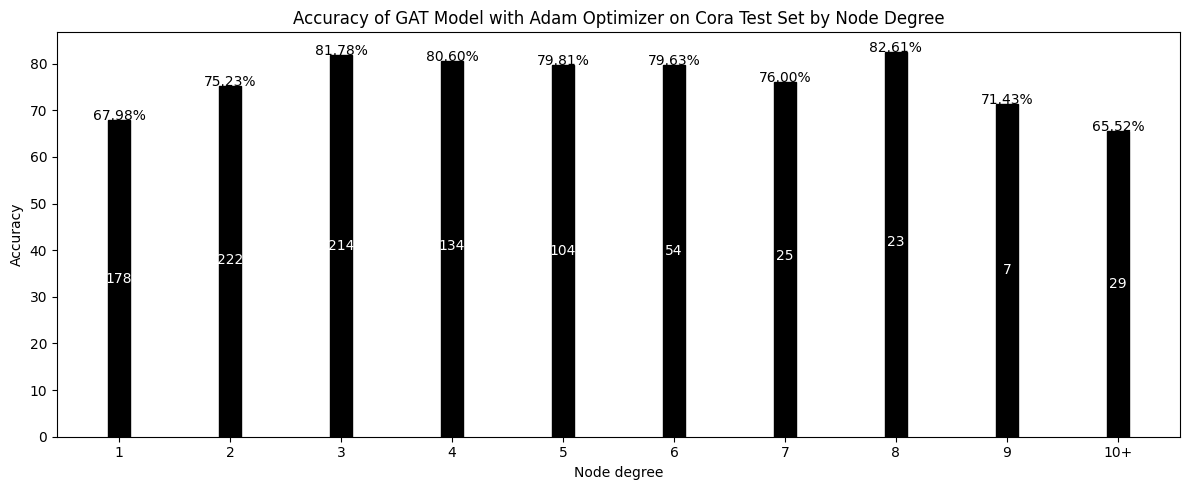

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return (sum(y_pred == y_true) / len(y_true))*100

# Get model's classifications
out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()
# Select degrees of nodes in test set
degrees=degrees[data.test_mask.numpy()]

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
pred = probas.argmax(dim=1)

# Test data
true_labels = data.y[data.test_mask].cpu().numpy()
predicted_labels = pred[data.test_mask].cpu().numpy()

# Accuracy for degrees between 0 and 5
for i in range(1, 10):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(predicted_labels[mask], true_labels[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 10
mask = np.where(degrees > 10)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy')
plt.bar(['1','2','3','4','5','6','7','8','9','10+'], accuracies, width=0.2, color='black', edgecolor='black')
for i in range(0, 10):
    plt.text(i, accuracies[i], f'{accuracies[i]:.2f}%', ha='center', color='black')
for i in range(0, 10):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

plt.title('Accuracy of GAT Model with Adam Optimizer on Cora Test Set by Node Degree')
plt.tight_layout()
plt.savefig('GAT_Cora_Adam_Accuracy_by_Degree.png')

plt.show()